# Clustering embeddings

**Goal**: we want to assign embeddings to a small number of clusters that can be used as tokens for training the sequence model.

### Questions 
- how well does dimensionality reduction retain the signal from the embeddings?
- how does is this clustering method affected by data drift (emergence of new clusters) in comparison to the fibonacci spirals?


In [1]:
from pop2vec.clustering.core import estimate_and_evaluate
from pop2vec.clustering.utils import create_fake_embs
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

In [2]:
n_true_clusters = 100
N = 5_000
n_clusters = 50
embs = create_fake_embs(n=N, n_clusters=n_true_clusters)
embs.head()


rinpersoon_id,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16,emb_17,emb_18,emb_19,emb_20,emb_21,emb_22,emb_23,emb_24,emb_25,emb_26,emb_27,emb_28,emb_29,emb_30,emb_31,emb_32,emb_33,emb_34,emb_35,…,emb_91,emb_92,emb_93,emb_94,emb_95,emb_96,emb_97,emb_98,emb_99,emb_100,emb_101,emb_102,emb_103,emb_104,emb_105,emb_106,emb_107,emb_108,emb_109,emb_110,emb_111,emb_112,emb_113,emb_114,emb_115,emb_116,emb_117,emb_118,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2.1305464e7,-0.213316,1.333806,-0.722679,-0.691175,0.37397,-2.079463,0.42536,1.549121,-2.092085,2.099525,0.314328,-0.702425,-0.664337,-1.109668,-0.264242,1.3927,2.507917,-2.310087,-0.838001,-1.066935,0.592554,0.080505,-0.044678,0.93651,0.431383,-1.679147,-1.2058,0.389131,0.971452,-0.922678,1.428286,0.085059,0.286777,-0.986932,0.848464,0.804543,…,-0.135719,2.126077,0.505655,-1.215538,0.08457,0.664232,1.503406,-0.175477,2.314505,0.059502,0.828508,-0.524003,-0.375825,0.481494,-0.895639,-0.735627,-0.112666,-0.15024,1.716603,-1.589387,0.325253,0.39753,-1.096784,0.372289,-0.516186,-1.108823,0.075864,1.136785,-0.008379,1.542347,1.528352,0.445123,-2.329339,-0.070772,-0.924558,0.389557,-1.332973
9.9889149e7,0.155336,-0.104112,1.143568,-0.786084,0.851439,-2.316372,0.011305,-0.366384,-0.51707,-3.364423,-3.073762,0.778044,-0.952485,1.421476,-1.308514,-0.197434,0.419232,-0.044611,-2.092559,-1.171616,-0.176189,2.93049,1.250862,-1.736784,2.957706,1.706284,0.235459,0.187914,0.473942,1.883633,-0.597879,0.868457,-0.175557,0.718949,4.815704,-1.328491,…,-0.299578,-0.150166,0.685812,0.631295,-1.057878,0.353843,0.11694,2.329292,-1.946485,-1.971134,0.974482,-1.010047,-1.034492,-1.526842,-0.484726,1.559271,-0.870351,-1.011258,0.176164,1.317489,-2.448623,-3.849323,0.455788,-0.581664,-0.320363,1.158834,-0.416784,4.34025,-0.970341,2.559042,1.417338,-0.259201,-0.859436,2.182196,-0.566283,0.982575,-0.620694
8.2915427e7,0.052959,-1.512516,0.205665,1.591978,-1.005937,-0.567214,-0.770374,-0.594278,0.576047,-1.112445,-0.526463,-0.548961,0.410436,-0.418097,0.388404,-0.388464,0.645415,-1.379997,0.068983,0.704192,-1.593321,0.239326,0.469142,-2.231888,-0.79163,-1.668307,-0.57142,1.948137,0.256538,-1.417431,0.030078,1.387468,0.080526,-1.18183,-1.072245,0.71978,…,0.871453,-2.690321,0.05384,-0.397767,0.0935,-0.248081,-0.694522,-0.866862,2.402473,-0.38937,-1.112085,0.772244,1.264123,-3.210014,2.964325,-0.54438,0.302591,-0.477222,-0.292167,0.512186,0.971471,2.427699,-2.12406,-0.288819,0.377316,-2.708637,0.827008,-0.189601,-1.214942,1.448872,-1.897432,-1.637107,1.230283,-0.267605,0.869986,-0.149412,2.217718
1.477957e7,-2.201408,-2.062062,-0.123197,-1.037775,-0.675048,0.409024,0.387576,-0.944616,0.016972,1.637703,-0.33305,-0.999868,0.721804,0.382103,-0.430299,-0.328483,-3.415176,0.437969,-0.976603,3.288827,-1.489413,1.358466,-0.910461,1.843251,1.816393,1.443565,0.152492,-0.534767,0.089574,3.333856,-0.816119,1.439952,-0.252635,-0.055728,1.431987,-0.107889,…,0.872685,0.263133,1.582344,2.332126,-1.201275,-1.599917,-2.998684,1.179174,1.554387,0.396673,2.0087,0.03282,1.081586,1.178172,0.683594,2.653616,-0.393748,-0.485927,-1.364584,2.716804,-1.894892,-1.208281,-0.194659,1.463347,1.535476,1.540444,1.304665,-1.045766,0.766704,-1.844401,-1.367467,-0.080474,-0.985131,-0.605933,0.816596,0.086652,0.228885
4.5928014e7,0.713053,-0.574186,-0.436064,0.567451,1.215648,-0.573159,0.934211,-1.940037,1.72742,-1.542618,-2.825346,-0.326244,-1.031937,-1.379814,0.952209,0.413099,1.274182,-1.00151,0.157947,1.247077,1.286165,1.587978,0.807631,2.466637,2.851519,0.406648,-2.352681,-0.339386,-0.508136,4.740031,-1.294843,-0.761877,-0.139914,1.057724,-0.344386,-1.26938,…,0.

/home/flavio/repositories/projects/odissei-life2vec/life-sequencing-dutch/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/flavio/repositories/projects/odissei-life2vec/life-sequencing-dutch/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/flavio/repositories/projects/odissei-life2vec/life-sequencing-dutch/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/flavio/repositories/projects/odissei-life2vec/life-sequencing-dutch/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:208: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


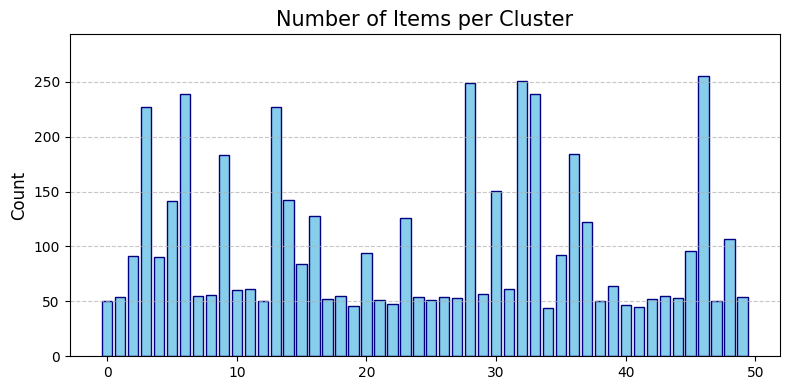

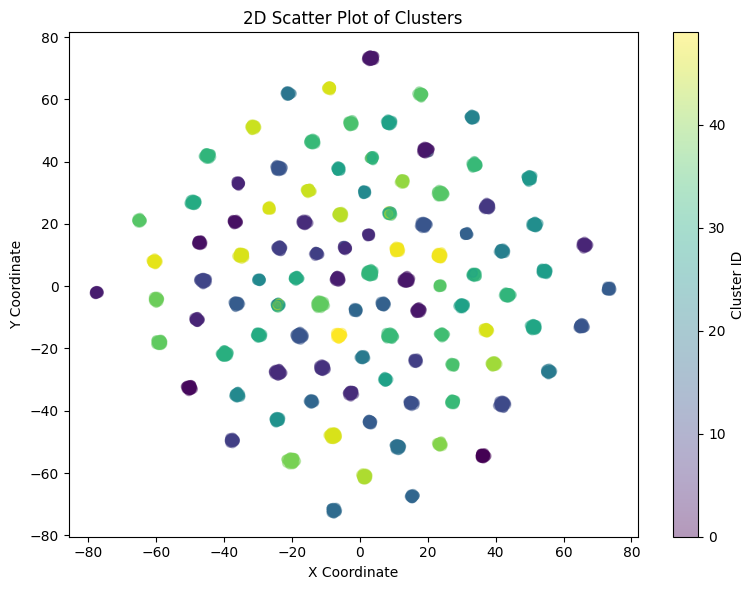

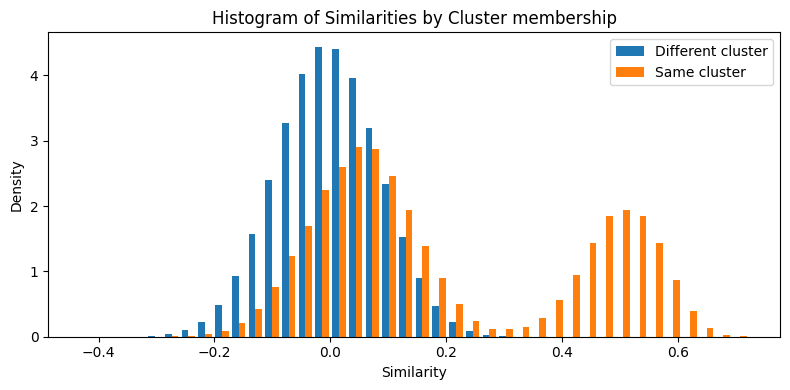

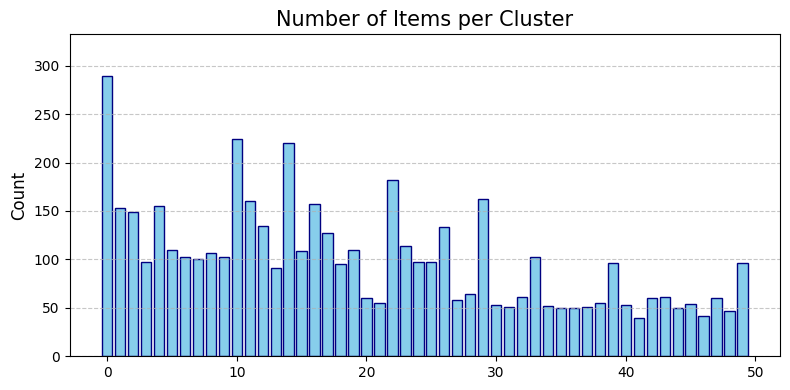

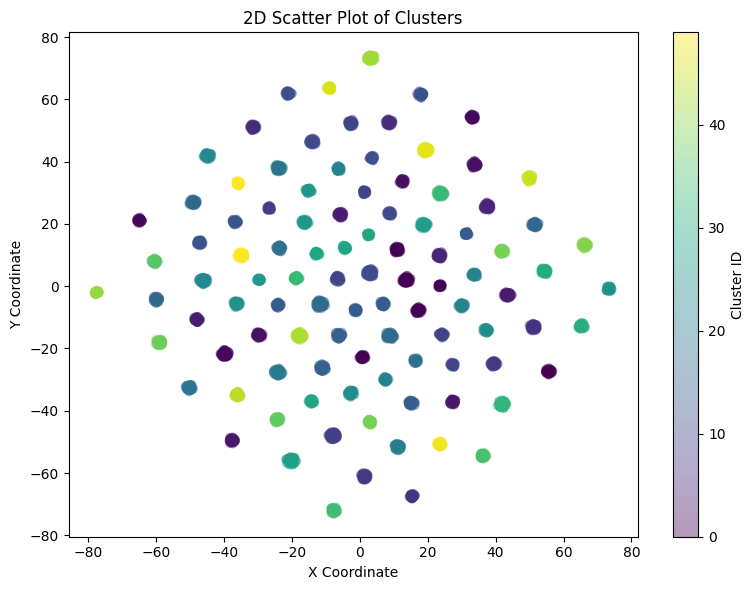

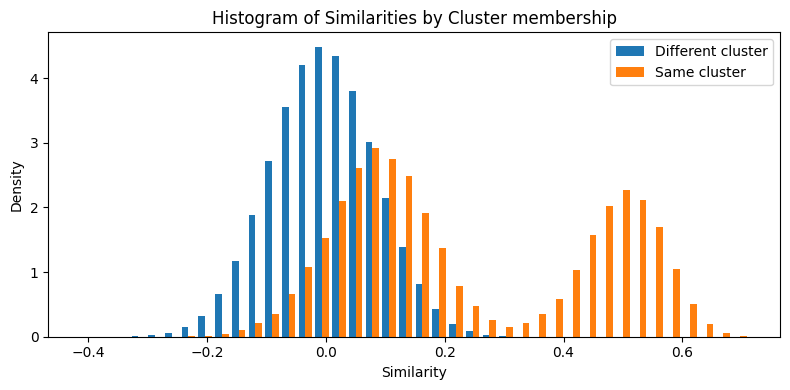

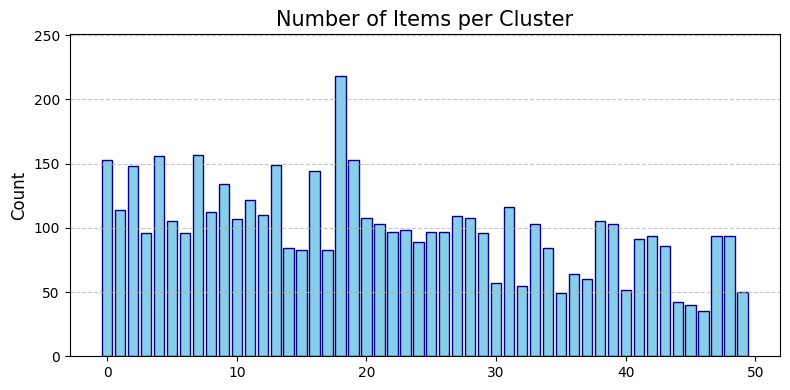

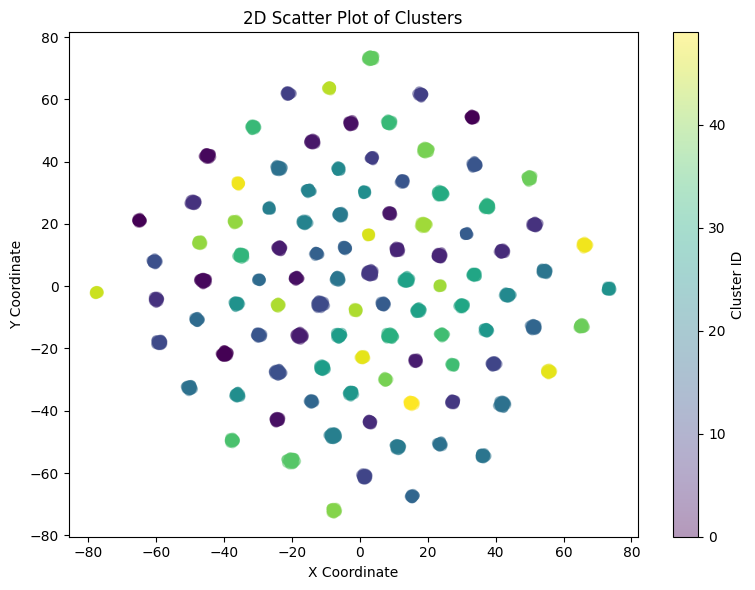

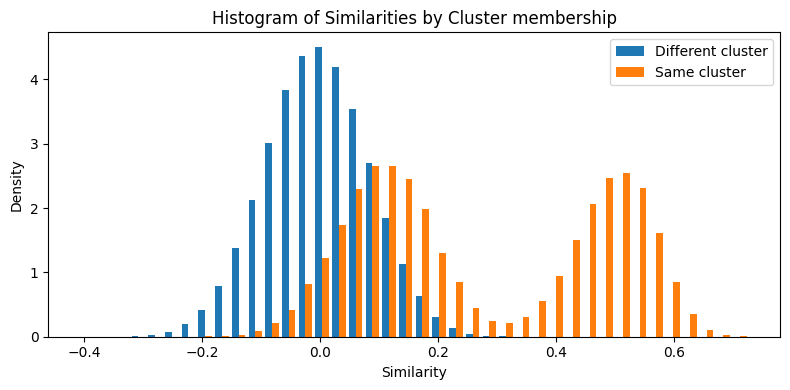

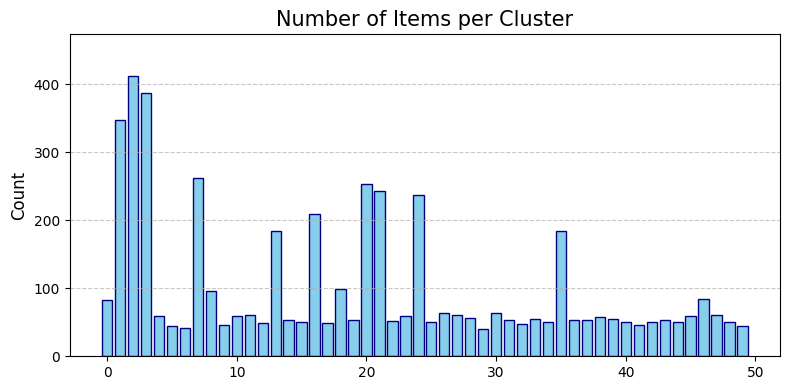

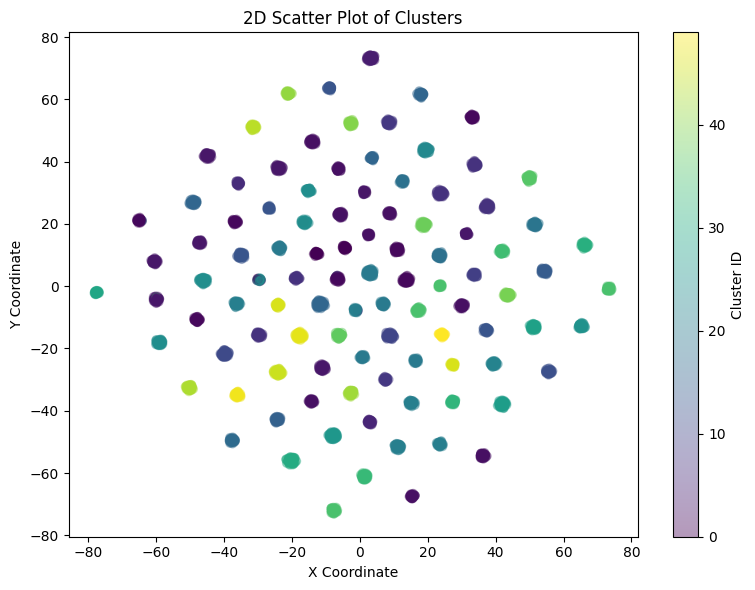

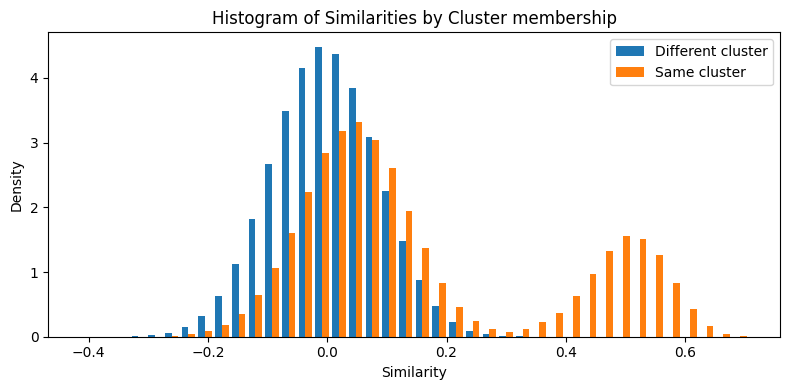

In [3]:
input_map = {
    "kmeans": KMeans(random_state=0, n_init="auto"),
    "agglom_base": AgglomerativeClustering(),
    "agglom_cosine": AgglomerativeClustering(metric="cosine", linkage="average"),
    "gmm": GaussianMixture()
}
results = {}
for name, estimator in input_map.items():
    results[name] = estimate_and_evaluate(name, estimator, embs, n_clusters) 


In [4]:
[(k, v["scores"]) for k,v in results.items()]

[('kmeans',
  {'silhouette': 0.17448221223787713,
   'calinski_harabasz': 41.31440540364569,
   'davies_bouldin': 2.6245339659762363}),
 ('agglom_base',
  {'silhouette': 0.20339425246053333,
   'calinski_harabasz': 46.02691628947992,
   'davies_bouldin': 2.5212464544147952}),
 ('agglom_cosine',
  {'silhouette': 0.21113351352843382,
   'calinski_harabasz': 44.18653534718789,
   'davies_bouldin': 2.4072270896736496}),
 ('gmm',
  {'silhouette': 0.16981231868088212,
   'calinski_harabasz': 40.902432277154034,
   'davies_bouldin': 2.617561103133424})]

### Summary
- agglomerative yields more equal-sized clusters
- little difference is closeness to own centroid
- the bivariate distributions are indicative of how well spatial information from original embeddings is preserved by clustering
- scoring metrics do not necessarily agree

To do next
- [x] look at bivariate distributions of cosine distances between units in same and different clusters
- [ ] ~~predict defining features of the network: municipality id? -> for clustering id, use the majority class or something?~~
- [ ] ~~spearman's rank correlation between the cluster centroid coordinates and the person coordinates~~
- [ ] make agglomerative more robust / use distance-specific stopping rule instead of hard-coded n clusters?

In [5]:
# TODO: use embs etc more consistently
# TODO: avoid copy from polars to numpy?
# TODO: add here the code to create the pairwise distributions and any further code
# TODO: update path for saving figures
# TODO: how do we run predict on new data? -> kmeans better? or use nearestcentroid?